### Hackaton #3 - Twitter Sentiment Analysis
---

#### Overview

* WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.

* Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value. As a team of data scientists consulting for WittyWicky Inc., you are now responsible for meeting their business outcomes.

#### Problem Statement

* Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

* You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

#### Dataset Description

* This dataset contains around 7k tweet text with the sentiment label.

* The file train.csv has 3 columns

* tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

#### Evaluation Metric

* We will be using ‘weighted’ F1-measure as the evaluation metric for this competition.
---

* Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import plotly
import plotly.tools as tls   
import plotly.graph_objs as go

* Functions

In [7]:
def remove_hash(text):
    hash_pat = r'#'
    return re.sub(hash_pat, ' ', text)

In [8]:
def remove_mention(text):
    mention_pat = r'@mention|@[a-z]+'
    return re.sub(mention_pat, ' ', text, flags=re.I)

In [9]:
def remove_short_link(text):
    short_link_pat = r"bit\.ly/[a-z0-9/\-:\.=%;,\+\*())&\$!@\[\]#\?~_\.']*"
    return re.sub(short_link_pat, ' ', text, flags=re.I) 

In [10]:
def remove_http_link(text):
    link_permit = r"[a-z0-9/\-:\.=%;,\+\*())&\$!@\[\]#\?~_\.']"
    http_link_pat = r"http[s]?://"+link_permit+"+|//"+link_permit+"+|[\w\.]+\.[a-z]+/"+link_permit+"+" 
    return re.sub(http_link_pat, ' ', text, flags=re.I)

In [11]:
def remove_sub_link(text):
    link_pat = r'{link}'
    return re.sub(link_pat, ' ', text, flags=re.I)

In [12]:
def remove_html_char(text):
    html_char_pat = r'&[a-z]+;'
    return re.sub(html_char_pat, ' ', text, flags=re.I)    

In [13]:
def remove_date(text):
    pipe = r'|'
    date_pat_mon = str()
    months =   [r'January',
                r'February',
                r'March',
                r'April',
                r'May',
                r'June',
                r'July',
                r'August',
                r'September',
                r'October',
                r'November',
                r'December']
    for month in months:
        date_pat_mon = date_pat_mon + month+r' \d\d, \d\d\d\d|'
        date_pat_mon = date_pat_mon + month[:3]+r' \d\d, \d\d\d\d|'
    
    date_pat_mon = date_pat_mon[:-1]
#     date_pat_mon
    date_pat =  r'\d\d/\d\d/\d\d\d\d|\d\d/\d\d/\d\d' + pipe + \
                r'\d\d\.\d\d\.\d\d\d\d|\d\d\.\d\d\.\d\d' + pipe + \
                r'\d\d-\d\d-\d\d\d\d|\d\d-\d\d-\d\d' + pipe + \
                r'{}'.format(date_pat_mon)
    date_pat = r'{}'.format(date_pat)
    return re.sub(date_pat, ' ', text, flags=re.I)

In [14]:
def remove_short_date(text):
    pipe = r'|'
    short_date_pat = r'[\d]?\d/\d\d[\d\d]?' + pipe + r'[\d]?\d\.\d\d[\d\d]?'
    short_date_pat = r'{}'.format(short_date_pat)
    return re.sub(short_date_pat, ' ', text)

In [15]:
def remove_time(text):
    pipe = r"|"
    time_pat =  r"\d\d:\d\d:\d\d[ ]?pm"+pipe+\
                r"\d\d:\d\d:\d\d[ ]?am"+pipe+\
                r"\d\d:\d\d:\d\d"+pipe+\
                r"\d\d:\d\d:\d\d"+pipe+\
                r"[\d]?\d:\d\d[ ]?pm"+pipe+\
                r"[\d]?\d:\d\d[ ]?am"+pipe+\
                r"[\d]?\d:\d\d"+pipe+\
                r"[\d]?\d:\d\d"+pipe+\
                r"[\d]?\d.\d\d[ ]?pm"+pipe+\
                r"[\d]?\d.\d\d[ ]?am"+pipe+\
                r"[\d]?\d.\d\d"+pipe+\
                r"[\d]?\d.\d\d"
    time_pat= r"{}".format(time_pat)
    return re.sub(time_pat, ' ', text, flags=re.I)

In [16]:
def remove_punctuation(text):
    punctuation_pat_s = r'\'s'
    punctuation_pat_t = r'\'t'
    punctuation_pat_d = r'\'d'
    punctuation_pat_ve = r'\'ve'
    punctuation_pat_ll = r'\'ll'
    temp = text
    temp = re.sub(punctuation_pat_s, ' ', temp, flags=re.I)
    temp = re.sub(punctuation_pat_t, 't', temp, flags=re.I)
    temp = re.sub(punctuation_pat_d, ' would', temp, flags=re.I)
    temp = re.sub(punctuation_pat_ve, ' have', temp, flags=re.I)
    temp = re.sub(punctuation_pat_ll, ' will', temp, flags=re.I)
    return temp

In [17]:
def remove_rt(text):
    rt_pat = r'RT '
    return re.sub(rt_pat, ' ', text)

In [18]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return re.sub(emoji_pattern,'', text)

In [19]:
def remove_not_alnum(text):
    """
    remove everything that is not alpha numeric
    """
    only_text = r'[^a-z0-9 ]'
    return re.sub(only_text, ' ', text, flags=re.I)    

In [20]:
def clean_text(text):
    
    #replace links witn {link}
    text = remove_short_link(text)
    text = remove_http_link(text)
    #remove {link}
    text = remove_sub_link(text)
    #hash
    text = remove_hash(text)
    #mention
    text = remove_mention(text)
    #rt
    text = remove_rt(text)
    #html spl chars
    text = remove_html_char(text)
    #time
    text = remove_time(text)
    #date
    text = remove_date(text)
    text = remove_short_date(text)
    #punctuation
    text = remove_punctuation(text)
    #emotjis
    text = remove_emojis(text)
    #remove spl chars
    text = remove_not_alnum(text)
    #return lower
    return text.lower()

In [21]:
def remove_sxsw(text):
    sxsw_pat = r"sxsw[a-z]*"
    return re.sub(sxsw_pat, ' ', text, flags=re.I) 

In [22]:
def remove_austin_texas(text):
    austin_pat = r"austin"
    texas_pat = r"texas|tx"
    temp = text
    temp = re.sub(austin_pat, ' ', temp, flags=re.I) 
    temp = re.sub(texas_pat, ' ', temp, flags=re.I) 
    return temp

In [23]:
def vectorizer_fit_transform(vectorizer, X_train, X_test):
    """
    fit_transform vectorizer on X_train
    transfrom vectorizer on X_test
    return: transformed X_train and X_test
    """
    
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    return X_train_vectorized, X_test_vectorized

In [24]:
def fit_models(X_train, X_test, y_train, y_test):
    """
    Fit models and display classification report
    """
    rf = RandomForestClassifier()
    gb = GradientBoostingClassifier()
    lr = LogisticRegression()
    for model, name in zip([rf,gb,lr],['RandomForestClassifier','GradientBoostingClassifier','LogisticRegression']):
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print(f'CLF report for {name}')
        print(classification_report(y_test, y_pred))
        print('---')

* Pulling data

In [25]:
data = pd.read_csv('data/train.csv')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 3 columns):
tweet_id     7274 non-null int64
tweet        7273 non-null object
sentiment    7274 non-null int64
dtypes: int64(2), object(1)
memory usage: 170.6+ KB


* Initial checks on data

In [27]:
data.head(10)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1
5,966,#technews One lone dude awaits iPad 2 at Apple...,1
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2
9,883,I think I might go all weekend without seeing ...,2


In [28]:
sentiments_dist = pd.DataFrame(data.sentiment.value_counts(normalize=True)*100)
sentiments_dist

,sentiment
1,59.265878
2,32.746769
0,6.268903
3,1.718449


In [29]:
sentiments_desc = { 0: 'Negative', 1: 'Neutral', 2: 'Positive', 3: 'Cannot Tell'}

In [30]:
sentiments_dist.index = sentiments_dist.index.map(lambda x: sentiments_desc[x])

In [31]:
# sentiments_dist

In [110]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(
                             labels=sentiments_dist.index,
                             values=sentiments_dist.sentiment,
                             hole=.5,
                             textposition = 'outside',
                             textinfo='label+percent',
                             marker=dict( line=dict(color='#000000', width=2))
                                        )])
fig.update_layout(
    showlegend=False,
    title={
        'text': "Distribution of Classes",
        'y':.9,
        'x':.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    width=500,
    height=500
)
fig.show()


In [33]:
# nltk.download('popular')

In [34]:
sentiments_all = '\n'.join(data['tweet'].astype(str))

In [35]:
# sentiments_all

In [36]:
tokenizer = TreebankWordTokenizer()

In [37]:
#Unique tokens

tokens = tokenizer.tokenize(sentiments_all)

print(f'Unique unprocessed tokens - {len(set(tokens))}')

Unique unprocessed tokens - 12993


In [38]:
# Unique lower cases tokens

tokens_lower = [text.lower() for text in tokens]
tokens_lower_count = len(set(tokens_lower))

print(f'Unique lower case unprocessed tokens - {tokens_lower_count}')

Unique lower case unprocessed tokens - 10744


In [39]:
# ls = LancasterStemmer()
ps = PorterStemmer()

In [40]:
# Unique lower case + porter stemmed tokens

tokens_lower_ps = [ps.stem(text) for text in tokens_lower]
tokens_lower_ps_count = len(set(tokens_lower_ps))

print(f'Unique lower case stemmed tokens - {tokens_lower_ps_count}')

Unique lower case stemmed tokens - 9021


In [41]:
# Unique lower case + porter stemmed (w/o) stop words tokens

# Load stop words
stop_words = set(stopwords.words('english'))

tokens_lower_ps_stw = [text for text in tokens_lower_ps if text not in stop_words]
tokens_lower_ps_stw_count = len(set(tokens_lower_ps_stw))
print(f'Unique lower case stemmed tokens - {tokens_lower_ps_stw_count}')

Unique lower case stemmed tokens - 8915


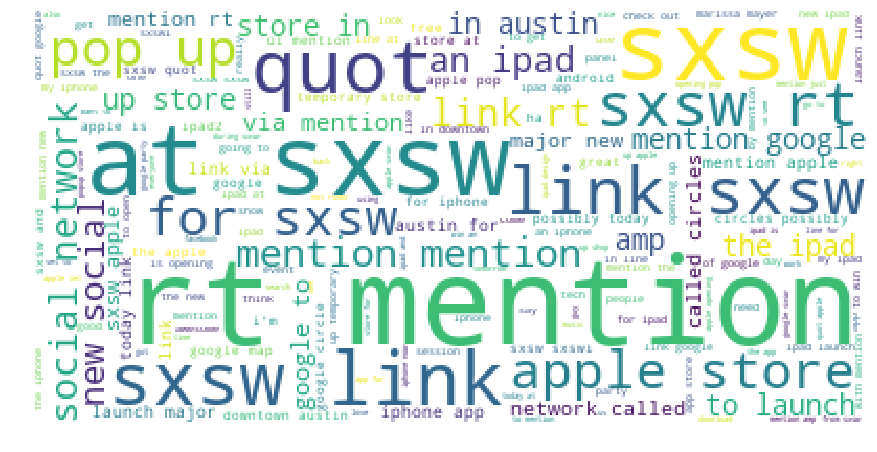

In [42]:
# Create a word cloud

wc = WordCloud(stopwords=stop_words, background_color='white', max_words=500).generate(sentiments_all.lower())

%matplotlib inline
plt.figure(figsize=(15, 10))
plt.clf()
plt.imshow(wc)
plt.axis('off')
plt.show()


#### Initial Sentiment Analysis

* Basic

In [43]:
# X, y split

X = data.tweet.astype(str)
y = data.sentiment

In [44]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10)

1. CountVectorizer - vanilla

In [45]:
# Initialize CountVectorizer - vanilla
cv = CountVectorizer()
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [46]:
X_train_cv, X_test_cv = vectorizer_fit_transform(cv, X_train, X_test)

In [47]:
X_train_cv.shape

(5819, 8035)

In [48]:
fit_models(X_train_cv, X_test_cv, y_train, y_test)

CLF report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.70      0.26      0.38        89
           1       0.67      0.90      0.77       857
           2       0.69      0.39      0.50       485
           3       0.00      0.00      0.00        24

    accuracy                           0.67      1455
   macro avg       0.51      0.39      0.41      1455
weighted avg       0.67      0.67      0.64      1455

---
CLF report for GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.65      0.12      0.21        89
           1       0.66      0.94      0.78       857
           2       0.71      0.31      0.43       485
           3       0.09      0.04      0.06        24

    accuracy                           0.66      1455
   macro avg       0.53      0.35      0.37      1455
weighted avg       0.67      0.66      0.61      1455

---
CLF report for LogisticRegression
        

/Users/Aniket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



2. TfidfVectorizer - vanilla

In [49]:
# Initialize TfidfVectorizer - vanilla
tf = TfidfVectorizer()
tf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [50]:
X_train_tf, X_test_tf = vectorizer_fit_transform(tf, X_train, X_test)

In [51]:
X_train_tf.shape

(5819, 8035)

In [52]:
fit_models(X_train_tf, X_test_tf, y_train, y_test)

CLF report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.77      0.26      0.39        89
           1       0.67      0.90      0.77       857
           2       0.68      0.37      0.48       485
           3       0.00      0.00      0.00        24

    accuracy                           0.67      1455
   macro avg       0.53      0.38      0.41      1455
weighted avg       0.67      0.67      0.64      1455

---
CLF report for GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.63      0.13      0.22        89
           1       0.66      0.92      0.77       857
           2       0.67      0.31      0.42       485
           3       0.00      0.00      0.00        24

    accuracy                           0.65      1455
   macro avg       0.49      0.34      0.35      1455
weighted avg       0.65      0.65      0.61      1455

---
CLF report for LogisticRegression
        

/Users/Aniket/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



3. CountVectorizer - ngram_range=(1, 2)

In [53]:
# Initialize CountVectorizer - ngram_range=(1, 2)
cv2 = CountVectorizer(ngram_range=(1, 2))
cv2

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [54]:
X_train_cv2, X_test_cv2 = vectorizer_fit_transform(cv2, X_train, X_test)

In [55]:
X_train_cv2.shape

(5819, 45721)

In [56]:
fit_models(X_train_cv2, X_test_cv2, y_train, y_test)

CLF report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.68      0.26      0.37        89
           1       0.65      0.92      0.76       857
           2       0.70      0.31      0.42       485
           3       0.00      0.00      0.00        24

    accuracy                           0.66      1455
   macro avg       0.51      0.37      0.39      1455
weighted avg       0.66      0.66      0.61      1455

---
CLF report for GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.65      0.12      0.21        89
           1       0.66      0.94      0.77       857
           2       0.71      0.31      0.43       485
           3       0.00      0.00      0.00        24

    accuracy                           0.66      1455
   macro avg       0.50      0.34      0.35      1455
weighted avg       0.66      0.66      0.61      1455

---
CLF report for LogisticRegression
        

/Users/Aniket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



4. TfidfVectorizer - ngram_range=(1, 2)

In [57]:
# Initialize TfidfVectorizer - ngram_range=(1, 2)
tf2 = TfidfVectorizer(ngram_range=(1, 2))
tf2

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [58]:
X_train_tf2, X_test_tf2 = vectorizer_fit_transform(tf2, X_train, X_test)

In [59]:
fit_models(X_train_tf2, X_test_tf2, y_train, y_test)

CLF report for RandomForestClassifier
              precision    recall  f1-score   support

           0       0.71      0.25      0.37        89
           1       0.66      0.92      0.77       857
           2       0.69      0.33      0.45       485
           3       0.00      0.00      0.00        24

    accuracy                           0.67      1455
   macro avg       0.51      0.37      0.40      1455
weighted avg       0.66      0.67      0.62      1455

---
CLF report for GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.59      0.11      0.19        89
           1       0.67      0.92      0.77       857
           2       0.69      0.34      0.45       485
           3       0.00      0.00      0.00        24

    accuracy                           0.66      1455
   macro avg       0.49      0.34      0.35      1455
weighted avg       0.66      0.66      0.62      1455

---
CLF report for LogisticRegression
        

/Users/Aniket/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [60]:
# remove_hash(sample)

In [61]:
# remove_mention(sample)

In [62]:
# remove_link(sample)

In [63]:
# remove_rt(sample)

In [64]:
# remove_not_alnum(sample)

#### Checking for links

In [65]:
links = []
http_link_pat = r'http[s]?://[a-z0-9/\._-]+||//[a-z0-9/\._-]+|[\w\.]+\.[a-z]+/[a-z0-9/\._-]+' 
for t in tokens:
    temp = list(re.findall(http_link_pat, t, flags=re.I))
    [links.append(x) for x in temp if x not in links]
len(links)

44

In [66]:
# replace links with pattern

#### Checking for emails

In [67]:
emails = []
email_pat = r'[a-z0-9_\.-]+@[a-z0-9]+\.[a-z]+\.?[a-z]*'
#     text = re.sub(email_pat, '', text, flags=re.I)
for t in tokens:
    temp = list(re.findall(email_pat, t, flags=re.I))
    [emails.append(x) for x in temp if x not in emails]
len(emails)

0

In [68]:
# no emails found

In [69]:
# data.loc[0,'tweet']

In [70]:
# clean_text(data.loc[0,'tweet'])


In [71]:
#### html tags

In [72]:
html_tags = []
html_tag_pat = r'&[a-z]+;'
for t in sentiments_all.split(' '):
    temp = re.findall(html_tag_pat, t, flags=re.I)
    if temp != []:
        html_tags.append(temp)
len(html_tags)

2011

In [73]:
# html_tags

In [74]:
short_links = []
short_link_pat = r'bit\.ly/.*'
# short_link_pat = r'.*[\./].*'

for t in sentiments_all.split(' '):
    temp = re.findall(short_link_pat, t, flags=re.I)
    if temp != []:
        short_links.append(temp)
len(short_links)

21

In [75]:
# short_links

In [76]:
remove_punctuation('couldn\'t they\'d ipad\'s')

'couldnt they would ipad '

In [77]:
sample = "RT This is a sample text. #sampleh @samplem ok... \
This is #a_sample as well???// I couldn\'t use this linkk: {link} @mention \
use: bit.ly/bgbBBHH55=&+-%$#455 \
or use: link - https://stackoverflow.com/questions/71...09143/w_hat-charac~ters-are-val'i'd-in-a-url=%;,+()&$![@]#?iu''?weyf \
Apple should've implemented the new app, then they'll be more safe otherwise they'd be facing a backlash, wouldn't they? \
They're gonna do it imo. Let's wait \
html: &quot; &Amp;  \
time: 23:59 PM ... 2.44 2:34 pm .. 12:45 AM .. 12:46:09 PM .. 12:47:07 .. 1.34 am 1.33am 1.44 . 12:22 1:26 ///.? \
date: 23-05-2017 06/17 7/17 24-05-2018 25.05.2019 \
&tag; xyz &title;\
"
# sample

In [78]:
sample_cleaned = clean_text(sample)
sample_cleaned

' this is a sample text   sampleh   ok    this is  a sample as well      i couldnt use this linkk      use    or use  link     apple should have implemented the new app  then they will be more safe otherwise they would be facing a backlash  wouldnt they  they re gonna do it imo  let  wait html       time                                            date                    xyz  '

###### tokenizer.tokenize(sample_cleaned)

In [79]:
# link = "link - https://stackoverflow.com/questions/71...09143/w_hat-charac~ters-are-val'i'd-in-a-url=%;,+()&$![@]#?iu''?weyf"


In [80]:
# replace_http_link(link)

In [81]:
# clean_text(link)

In [82]:
import re
pipe = r"|"
time_pat =  r"\d\d:\d\d:\d\d[ ]?pm"+pipe+\
                r"\d\d:\d\d:\d\d[ ]?am"+pipe+\
                r"\d\d:\d\d:\d\d"+pipe+\
                r"\d\d:\d\d:\d\d"+pipe+\
                r"[\d]?\d:\d\d[ ]?pm"+pipe+\
                r"[\d]?\d:\d\d[ ]?am"+pipe+\
                r"[\d]?\d:\d\d"+pipe+\
                r"[\d]?\d:\d\d"+pipe+\
                r"[\d]?\d.\d\d[ ]?pm"+pipe+\
                r"[\d]?\d.\d\d[ ]?am"+pipe+\
                r"[\d]?\d.\d\d"+pipe+\
                r"[\d]?\d.\d\d"
time_pat= r"{}".format(time_pat)
re.findall(time_pat,'2:34 pm .. 12:45 AM .. 12:46:09 PM .. 12:47:07 .. 1.33 pm 1.44 . 12:22 1:26 8.35pm',flags=re.I)

['2:34 pm',
 '12:45 AM',
 '12:46:09 PM',
 '12:47:07',
 '1.33 pm',
 '1.44',
 '12:22',
 '1:26',
 '8.35pm']

In [83]:
remove_sxsw('this is an example of sxswnui sxsw removal')

'this is an example of     removal'

In [84]:
remove_austin_texas('event was held at Austin TeXas TX')

'event was held at      '

In [85]:
html_char_pat = r'&[a-z]+;'

In [86]:
txt = 'RT staRT: art this is an example with 1 RT'
rt_pat = r'^RT'
txt = re.sub(rt_pat, ' ', txt,flags=re.I)
txt

'  staRT: art this is an example with 1 RT'

In [87]:
re.findall(r"[<>\"]",sentiments_all)

[]

In [88]:
re.findall("."*4+"&"+"."*4,sentiments_all)

['nny &amp;',
 'ion &quot',
 'erts&quot',
 'ore &amp;',
 'sic &gt; ',
 '... &gt;&',
 'top &amp;',
 'ng, &amp;',
 'SW: &quot',
 'nts.&quot',
 'ly! &gt;&',
 'ear &amp;',
 'ion &quot',
 'far.&quot',
 'r...&gt; ',
 'ion &quot',
 'ture&quot',
 'w!! &amp;',
 'nk} &lt;-',
 'ies,&amp;',
 'ork &quot',
 'cles&quot',
 'ion &quot',
 'gle.&quot',
 'SDM &amp;',
 'sw: &quot',
 'nces&quot',
 'ion &quot',
 'one.&quot',
 'd 2.&quot',
 ' u? &quot',
 'oday&quot',
 '2 AT&amp;',
 'for &quot',
 'ing!&quot',
 'ple &amp;',
 'ter &amp;',
 'xth &amp;',
 'SW =&gt; ',
 'llo &amp;',
 'Mac &amp;',
 'rry &amp;',
 'nk} &amp;',
 'ch!.&quot',
 'Û_] &quot',
 'XSW &quot',
 'er: &quot',
 's...&quot',
 'XSW &quot',
 'ogle&quot',
 'ion &amp;',
 'gle &quot',
 'nces&quot',
 '.la &lt; ',
 'XSW &amp;',
 ' God&quot',
 'tal &amp;',
 'ion &quot',
 'kes.&quot',
 'nch &quot',
 'here&quot',
 'rs: &quot',
 'ies?&quot',
 'ion &amp;',
 '-N-G&quot',
 'ion &quot',
 'ink.&quot',
 'Pad &amp;',
 'gn: &quot',
 'ble.&quot',
 '6th &amp;',
 'XSW 

In [89]:
re.findall(r"&lt;[/]?3|<3",sentiments_all)

['&lt;3', '&lt;3', '&lt;3', '&lt;3']

In [90]:
re.findall(":-\(",sentiments_all)

[':-(', ':-(', ':-(', ':-(', ':-(', ':-(']

In [91]:
re.findall("."*4+":[-]?[O\|o()xp#]+"+"."*4,sentiments_all,re.I)

[' aw :) #SX',
 'ya? :) @me',
 'XSW :)\x89Û\x9d ',
 'elf :( {li',
 'yay :) tha',
 'lts :( wil',
 'es. :) #go',
 'one :-)  {l',
 'eet :) RT ',
 'rs. :-) #Sx',
 '!!! :)) &qu',
 'ere :) RT ',
 'cts :) {li',
 'ion :) In ',
 'er? :) RT:',
 'd 2 :) I j',
 'tem :) #SX',
 "le's:) #SE",
 'too :-) RT ',
 'ad 2:) Tha',
 'ion :) RT ',
 'wn. :) {li',
 'PLE :) RT ',
 'hem :-( (vi',
 'PP. :( RT ',
 'id. :) RT ',
 ' !! :))  {l',
 'ot; :) (@m',
 'get :-( / e',
 'uss :-) #SX',
 ' Mac:PC ra',
 'iPad:Perso',
 'ion :) RT ',
 'pro :) RT ',
 'es. :)  RT',
 'ay. :) #SX',
 'ion :) RT ',
 'n?? :) RT ',
 'way :P #sx',
 '!!! :)) &qu',
 'in? :) #Ap',
 'ney :) #sx',
 'ent :-| #SX',
 'xsw :-) :-)',
 'tra :) RT ',
 'ty! :-) {li',
 'd 2 :) #ap',
 'd 2 :) I j',
 'ere :) RT ',
 'ate :-) {li',
 'xsw :( (@m',
 'd 2 :p RT ',
 'app :) rem',
 'dom :) You',
 'ou! :) RT ',
 'd 2 :( No,',
 'xsw :( Yes',
 'y.  :-(   {',
 'y.  :-(   {',
 'y.  :)   #',
 ' us :) #SX',
 'ng. :) #to',
 'ONE :)  It',
 ' aw :) #SX',
 'RY! :-) #SX',
 'n

In [92]:
re.findall("."*4+":'[-]?[\(\)]"+"."*4,sentiments_all)


[]

In [93]:
re.findall("."*4+";[-]?\)"+"."*4,sentiments_all)


['ta. ;-) {li',
 'run ;) {li',
 'er. ;) #an',
 'ain ;-). tu',
 'en. ;) {li',
 'ent ;-) RT ',
 'tin ;) #ip',
 'yle ;) \x89ÛÏ',
 'ion ;-) RT ',
 'Sw. ;) iPh',
 'pad ;) (@m',
 'irs ;) #sx',
 'ain ;-). tu',
 'ubt ;) RT ',
 'ime ;) #sx',
 'it! ;) RT ',
 'ol) ;) #SX',
 'ion ;) (32',
 'ded ;) #ap',
 'yet ;-) #sx',
 'en! ;) &qu']

#### Replace emoticons
* love
* not love
* happy
* sad
* playful
* wink
* straightface

In [94]:
r":-\("

':-\\('

In [95]:
def replace_text_emoji(text):
    love_pat = r"&lt;3+"
    happy_pat = r":[-]?[\)]+"
    sad_pat = r":[-]?[\(]+"
    playful_pat = r":[-]?[p]+"
    wink_pat = r";[-]?[\)]+"
    straightface_pat = r":[-]?[\|]+"
    
    #replace text emojis
    temp = text
    temp =  re.sub(love_pat, ' love ', temp)
    temp =  re.sub(happy_pat, ' smiley ', temp)
    temp =  re.sub(sad_pat, ' sad ', temp)
    temp =  re.sub(playful_pat, ' playful ', temp, flags=re.I)
    temp =  re.sub(wink_pat, ' wink ', temp)
    temp =  re.sub(straightface_pat, ' straightface ', temp)
    return temp

In [96]:
replace_text_emoji("&lt;3 &lt;3333 ... :); :))))) :-) :-)))))bnhdch:( :-( :-(((")

' love   love  ...  smiley ;  smiley   smiley   smiley bnhdch sad   sad   sad '

In [97]:
replace_text_emoji(":p :-P :-p :-PPP :-| :| ;) ;))) ;-)")

' playful   playful   playful   playful   straightface   straightface   wink   wink   wink '

In [98]:
amp_pat = r"."*4+r"&amp;"+r"."*4
amp_pat = r"{}".format(amp_pat)
re.findall(amp_pat,sentiments_all)

['nny &amp; inn',
 'ore &amp; And',
 'top &amp; jus',
 'ng, &amp; sky',
 'ear &amp; an ',
 "w!! &amp; I'm",
 'ies,&amp; ppl',
 'SDM &amp; #Go',
 '2 AT&amp;T 64',
 'ple &amp; Bes',
 'ter &amp; iPh',
 'xth &amp; Con',
 'llo &amp; Kil',
 "Mac &amp; I'm",
 'rry &amp; And',
 'nk} &amp; say',
 'ion &amp; @me',
 'XSW &amp; iPa',
 'tal &amp; Phy',
 'ion &amp; goo',
 'Pad &amp; my ',
 '6th &amp; Con',
 ' me &amp; @me',
 'Pad &amp; #iP',
 ' LA &amp; Jap',
 'are &amp; gow',
 '4/7 &amp; liv',
 'ng Q&amp;A on',
 'you &amp; ste',
 '/7) &amp; liv',
 'le (&amp; mor',
 'ter &amp; #iP',
 'ter &amp; iPh',
 'app &amp; rid',
 'rry &amp; And',
 'ign &amp; onl',
 'ion &amp; @me',
 'l AT&amp;T br',
 'ks! &amp; a p',
 '. AT&amp;T ad',
 'isa &amp; ANZ',
 'tal &amp; Phy',
 '6th &amp; Con',
 'ted &amp; doc',
 'Fun &amp; Fut',
 'ter &amp; iPh',
 'gle &amp; Dua',
 're R&amp;D? W',
 'sic &amp; wan',
 'cal &amp; kee',
 'ion &amp; @me',
 'ing &amp; rev',
 'sic &amp; wan',
 'co, &amp; Ata',
 'xth &amp; Con',
 'lla &amp

In [99]:
# trial = r"."*4+r"[^ ]*"+r"&amp;"+r"[^ ]*"+r"."*4
trial = r"[^ ]*"+r"&amp;"+r"[^ ]*"
trial = r"{}".format(trial)
re.findall(trial,sentiments_all)

['&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'techies,&amp;',
 '&amp;',
 'AT&amp;T',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '\r\nGSD&amp;M',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'Q&amp;A',
 '&amp;',
 '&amp;',
 '(&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'AT&amp;T',
 '#AT&amp;T\n@mention',
 '&amp;',
 'AT&amp;T',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'R&amp;D?',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'Q&amp;A',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 'Q&amp;A',
 '&amp;',
 '&amp;',
 '&amp;',
 'GSD&amp;M',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;',
 '&amp;

#### Replace:
    [ &amp; ] with ' '
    [^ ]&amp;[^ ] with '&'



In [100]:
sample2 = "sponsored by AT&amp;T &amp; some other company"

In [101]:
pat_amp = r"&amp;"
sample2_clean = re.sub(pat_amp, '&', sample2, flags=re.I)
sample2_clean

'sponsored by AT&T & some other company'

In [102]:
pat_amp2 = r" & | &|& "
sample2_clean2 = re.sub(pat_amp, ' ', sample2_clean)
sample2_clean2


'sponsored by AT&T & some other company'

In [103]:
pat_amp = r" &amp; "
pat_amp = r"{}".format(pat_amp)
# len(re.findall(pat_amp,sentiments_all,re.I))
re.findall(pat_amp,sentiments_all,re.I)

[' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &amp; ',
 ' &

In [104]:
def replace_amp(text):
    pat_amp = r"&amp;"
    return re.sub(pat_amp, '&', text, flags=re.I)

In [105]:
def remove_amp(text):
    pat_amp_single = r" & "
    return re.sub(pat_amp_single, '', text, flags=re.I)
    

In [106]:
sentiments_namp = ' '.join(data['tweet_namp'].astype(str))
re.findall(pat_amp,sentiments_namp,re.I)

KeyError: 'tweet_namp'

In [ ]:
len(re.findall(r" & ",sentiments_namp,re.I))

In [ ]:
data['tweet_namp'] = data['tweet'].astype(str).map(replace_amp)
data['tweet_namp']

In [ ]:
# data.decode("utf8").encode("ascii","ignore")
data.loc[10,'tweet']

In [ ]:
data.loc[10,'tweet'].encode("utf-8").decode("utf-8").encode("ascii","ignore")

In [ ]:
data.loc[10,'tweet'].encode("ascii","ignore")

In [ ]:
# data.loc[10,'tweet']#.encode("ascii","ignore")

In [ ]:
# 1352
tw=data[data.tweet_id==1352]['tweet']
str(tw).encode("utf-8").decode("utf-8").encode("ascii","ignore")

In [ ]:
data_asc = pd.read_csv('data/train.csv',encoding="utf-8")

In [ ]:
data_asc.drop(1274,axis=0,inplace=True)

In [ ]:
data_asc['tweet_ascii'] = data_asc['tweet'].map(lambda x: x.encode("utf-8").decode("utf-8").encode("ascii","ignore"))


In [ ]:
data_asc[data_asc.tweet_id==1352]['tweet_ascii']

In [ ]:
lt_pat = r"."*8+r"&lt;"+r"."*8
lt_pat = r"{}".format(lt_pat)
re.findall(lt_pat,sentiments_all)

In [ ]:
gt_pat = r"."*8+r"&gt;"+r"."*8
gt_pat = r"{}".format(gt_pat)
re.findall(gt_pat,sentiments_all)

In [109]:
html_syntax_pat = r"."*8+r"&lt;[//a-z]+&gt;"+r"."*8
html_syntax_pat = r"{}".format(html_syntax_pat)
re.findall(html_syntax_pat,sentiments_all)

['yed the &lt;title&gt; tag - w',
 'ing to? &lt;Seriously!&gt; {link} ',
 'RT #LOVE&lt;=&gt; Hey Aus',
 'yed the &lt;title&gt; tag - w',
 'on from &lt;video&gt; but inc']

#### Remove html syntax

In [ ]:
quot_pat = r"."*8+r"&quot;"+r"."*8
quot_pat = r"{}".format(quot_pat)
re.findall(quot_pat,sentiments_all)

In [ ]:
quot_pat = r"."*8+r":&quot;"+r"."*8
quot_pat = r"{}".format(quot_pat)
re.findall(quot_pat,sentiments_all)

#### Mappings

In [ ]:
# ipad 2 mapping

In [ ]:
ipad_pat = r"."*8+r"ipad[ ]2"+r"."*8
ipad_pat = r"{}".format(ipad_pat)
len(re.findall(ipad_pat,sentiments_all))

In [ ]:
ipad_pat = r"."*8+r"ipads"+r"."*8
ipad_pat = r"{}".format(ipad_pat)
re.findall(ipad_pat,sentiments_all)

In [ ]:
def map_ipad2(text):
    ipad2_pat = r"ipad[ ]+2[s]?"
    return re.sub(ipad2_pat, 'ipad2', text, flags=re.I)

In [ ]:
def map_ipads(text):
    ipads_pat = r"ipads"
    return re.sub(ipads_pat, 'ipad', text, flags=re.I)

In [ ]:
map_ipads("love the new iPad 2 ipads   2 ipad2s #ipad2 #iPad2")

In [ ]:
map_ipad2("love the new iPad 2 ipad   2s #ipad2 #iPad2")

In [ ]:
# iphone 

In [ ]:
iphone_pat = r"."*8+r"iphone"+r"."*8 #[ ]?[4]?
iphone_pat = r"{}".format(iphone_pat)
re.findall(iphone_pat,sentiments_all,re.I)

In [ ]:
def map_iphone4(text):
    iphone4_pat = r"iphone[ ]+4[s]?"
    return re.sub(iphone4_pat, 'iphone4', text, flags=re.I)

In [ ]:
map_iphone4("new iPhone 4 iPhone 4s #iphone iPhone 4")